In [11]:
import os
import scanpy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sys
import pandas as pd
import numpy as np
import scvi
scvi.settings.seed = 0
from sklearn.neighbors import KNeighborsClassifier

sys.path.append('..')
from custom_functions import *

import warnings
warnings.filterwarnings("ignore")

save_format = "tiff" 

Seed set to 0


In [12]:
dataset=sys.argv[1]
dataset='gastruloid'

In [13]:
if dataset=='gastruloid':
    data_folder = "data/gastruloid"
    analysis_name='gastruloid_prisca'
elif dataset=='mouse':
    data_folder = "data/mouse"
    analysis_name='mouse_pijuan'

if not os.path.isdir(f"results/{analysis_name}"):
    os.makedirs(f"results/{analysis_name}", exist_ok=True)
if not os.path.isdir(f"results/{analysis_name}/umap_genes"):
    os.makedirs(f"results/{analysis_name}/umap_genes", exist_ok=True)

# 0. Construct AnnData

In [14]:
construct_anndata=False

In [15]:
if construct_anndata:    
    if dataset=='gastruloid':
        # load mtx
        adata=sp.read_mtx(f'{data_folder}/GSE229513_UMI_counts.mtx.gz').T
        # load genes
        genes=pd.read_csv(f'{data_folder}/GSE229513_genes.tsv.gz', index_col=0)
        adata.var=genes
        # load genes
        cells=pd.read_csv(f'{data_folder}/GSE229513_barcodes.tsv.gz', index_col=0,header=None)
        cells.index.name='barcode'
        cells['cell'] = 'cell_' + pd.Series(np.arange(adata.shape[0]),index=cells.index).astype(str)
        cells['sample'] = pd.Series([x.split(':')[0].replace(' ','-') for x in cells.index.values], index=cells.index)
        cells['stage'] = pd.Series([x.split('-')[1].split('h')[0] for x in cells['sample'].values], index=cells.index) + 'h'
        adata.obs=cells
    
    elif dataset=='mouse':
        # custom list of samples to select (later stages have way more samples, pick only 6)
        with open(f'{data_folder}/pijuan_samples_selection.json', 'r') as file:
            samples2select=json.load(file)

        #load h5ad file
        adata=sp.read_h5ad(f'{data_folder}/embryo_complete.h5ad')
        ss= [sample for samples in samples2select.values() for sample in samples]
        adata = adata[adata.obs['sample'].isin(ss)]
        adata.var_names=adata.var['mgi_symbol']
        adata.var_names_make_unique()
        

## Save Anndata file

In [16]:
if construct_anndata:
    adata.write(f'{data_folder}/{analysis_name}_raw.h5ad')

# Analysis

- Parameters

In [17]:
parameters={'target_sum':10000,
            'metric': 'correlation',
            'n_top_genes':2000,
            'n_pcs':30,
            'pca_random_factor':3}
parameters

{'target_sum': 10000,
 'metric': 'correlation',
 'n_top_genes': 2000,
 'n_pcs': 30,
 'pca_random_factor': 3}

## Load adata

In [18]:
adata = sp.read_h5ad(f'{data_folder}/{analysis_name}_raw.h5ad')

# 1. QC
Each sample undergoes QC individually that checks on:
- % mitochondrial genes **< 10%**
- Min/Max thresholds of total counts
- Min/Max threshold of total genes

Then, adata is **filtered** accordingly

*Tresholds per batch of cells is computed automatedly by **qc_threshold** custom function*

In [19]:
adatas=[]

for batch in adata.obs['sample'].unique():
    print(f'Performing QC to {batch}')

    ad = adata[adata.obs['sample']==batch]
    ad.layers["counts"] = ad.X.copy() #save raw counts layer
    ad.var_names_make_unique()

    # % mito
    mt_max = 10 # Mt max threshold: 10%
    ad.var["mt"] = ad.var_names.str.startswith("Mt")
    sp.pp.calculate_qc_metrics(ad, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # min/max total and genes counts
    tc_min, tc_max= qc_threshold(ad.obs['total_counts'].values)
    g_min, g_max= qc_threshold(ad.obs['n_genes_by_counts'].values)

    # Plot QC metrics
    g = sns.JointGrid(data=ad.obs, x='total_counts', y='n_genes_by_counts', height=6)

    g.plot_marginals(sns.histplot, bins=30)

    sns.scatterplot(data=ad.obs, x='total_counts', y='n_genes_by_counts', 
                    hue='pct_counts_mt', ax=g.ax_joint)

    g.ax_joint.axvline(x=tc_min, color='red', linestyle='--', linewidth=1)
    g.ax_joint.axvline(x=tc_max, color='red', linestyle='--', linewidth=1)

    g.ax_joint.axhline(y=g_min, color='red', linestyle='--', linewidth=1)
    g.ax_joint.axhline(y=g_max, color='red', linestyle='--', linewidth=1)

    # save plot
    g.savefig(f"results/{analysis_name}/{batch}_qc_counts.{save_format}")   
    plt.close()

    ### adata filtering ###
    ad = ad[ad.obs["total_counts"] >= tc_min,:]
    ad = ad[ad.obs["total_counts"] <= tc_max,:]

    ad = ad[ad.obs["n_genes_by_counts"] >= g_min,:]
    ad = ad[ad.obs["n_genes_by_counts"] <= g_max,:]

    ad = ad[ad.obs["pct_counts_mt"] <= mt_max,:]

    # append processed adata
    adatas.append(ad)

adata=sp.concat(adatas, join='outer')
adata.obs.reset_index(drop=True, inplace=True)

Performing QC to S1-0h
Performing QC to S2-48h
Performing QC to S3-52h
Performing QC to S4-56h
Performing QC to S6-96h
Performing QC to S7.1-108h
Performing QC to S7.2-108h
Performing QC to S8.2-120h
Performing QC to SBR-24h
Performing QC to SBR-36h
Performing QC to SBR-48h
Performing QC to SBR-60h
Performing QC to SBR-72h
Performing QC to SBR-84h_A
Performing QC to SBR-84h_B


# 2. DR

## Preprocessing

In [20]:
sp.pp.normalize_total(adata,target_sum=parameters['target_sum'])
sp.pp.log1p(adata)

### HVG

In [21]:
sp.pp.highly_variable_genes(adata)

In [22]:
genes = pd.read_csv("cell_cycle_genes.txt",header=None).iloc[:,0].str.capitalize().values
for i in genes:
    if i in adata.var.index.values:
        adata.var.loc[i,"highly_variable"] = False

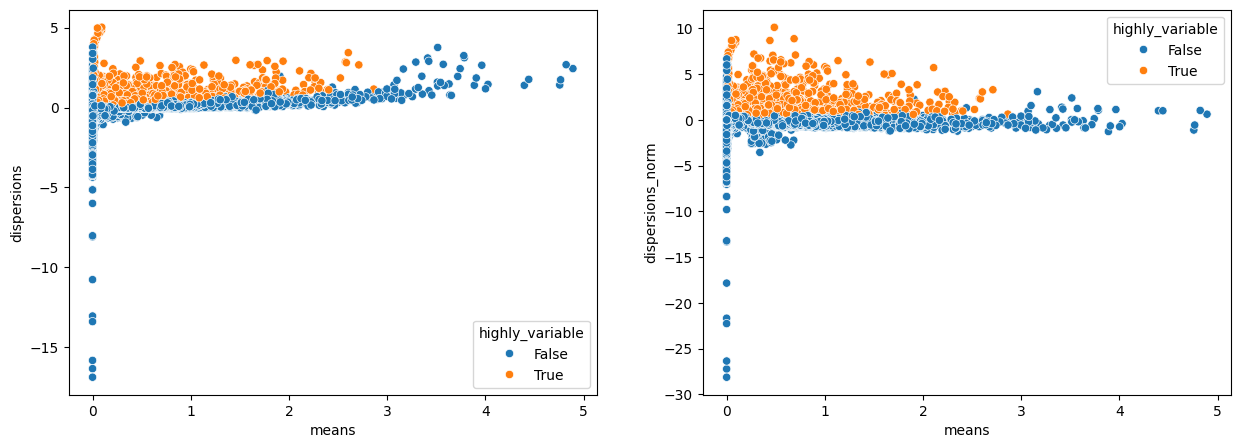

In [23]:
fig,ax = plt.subplots(1,2,figsize=[15,5])
sns.scatterplot(data = adata.var, x="means", y="dispersions", hue="highly_variable", ax=ax[0])
sns.scatterplot(data = adata.var, x="means", y="dispersions_norm", hue="highly_variable", ax=ax[1])
fig.savefig(f"results/{analysis_name}/dr_hvgs.{save_format}")        

### PCA

In [24]:
sp.pp.pca(adata,use_highly_variable=True)    

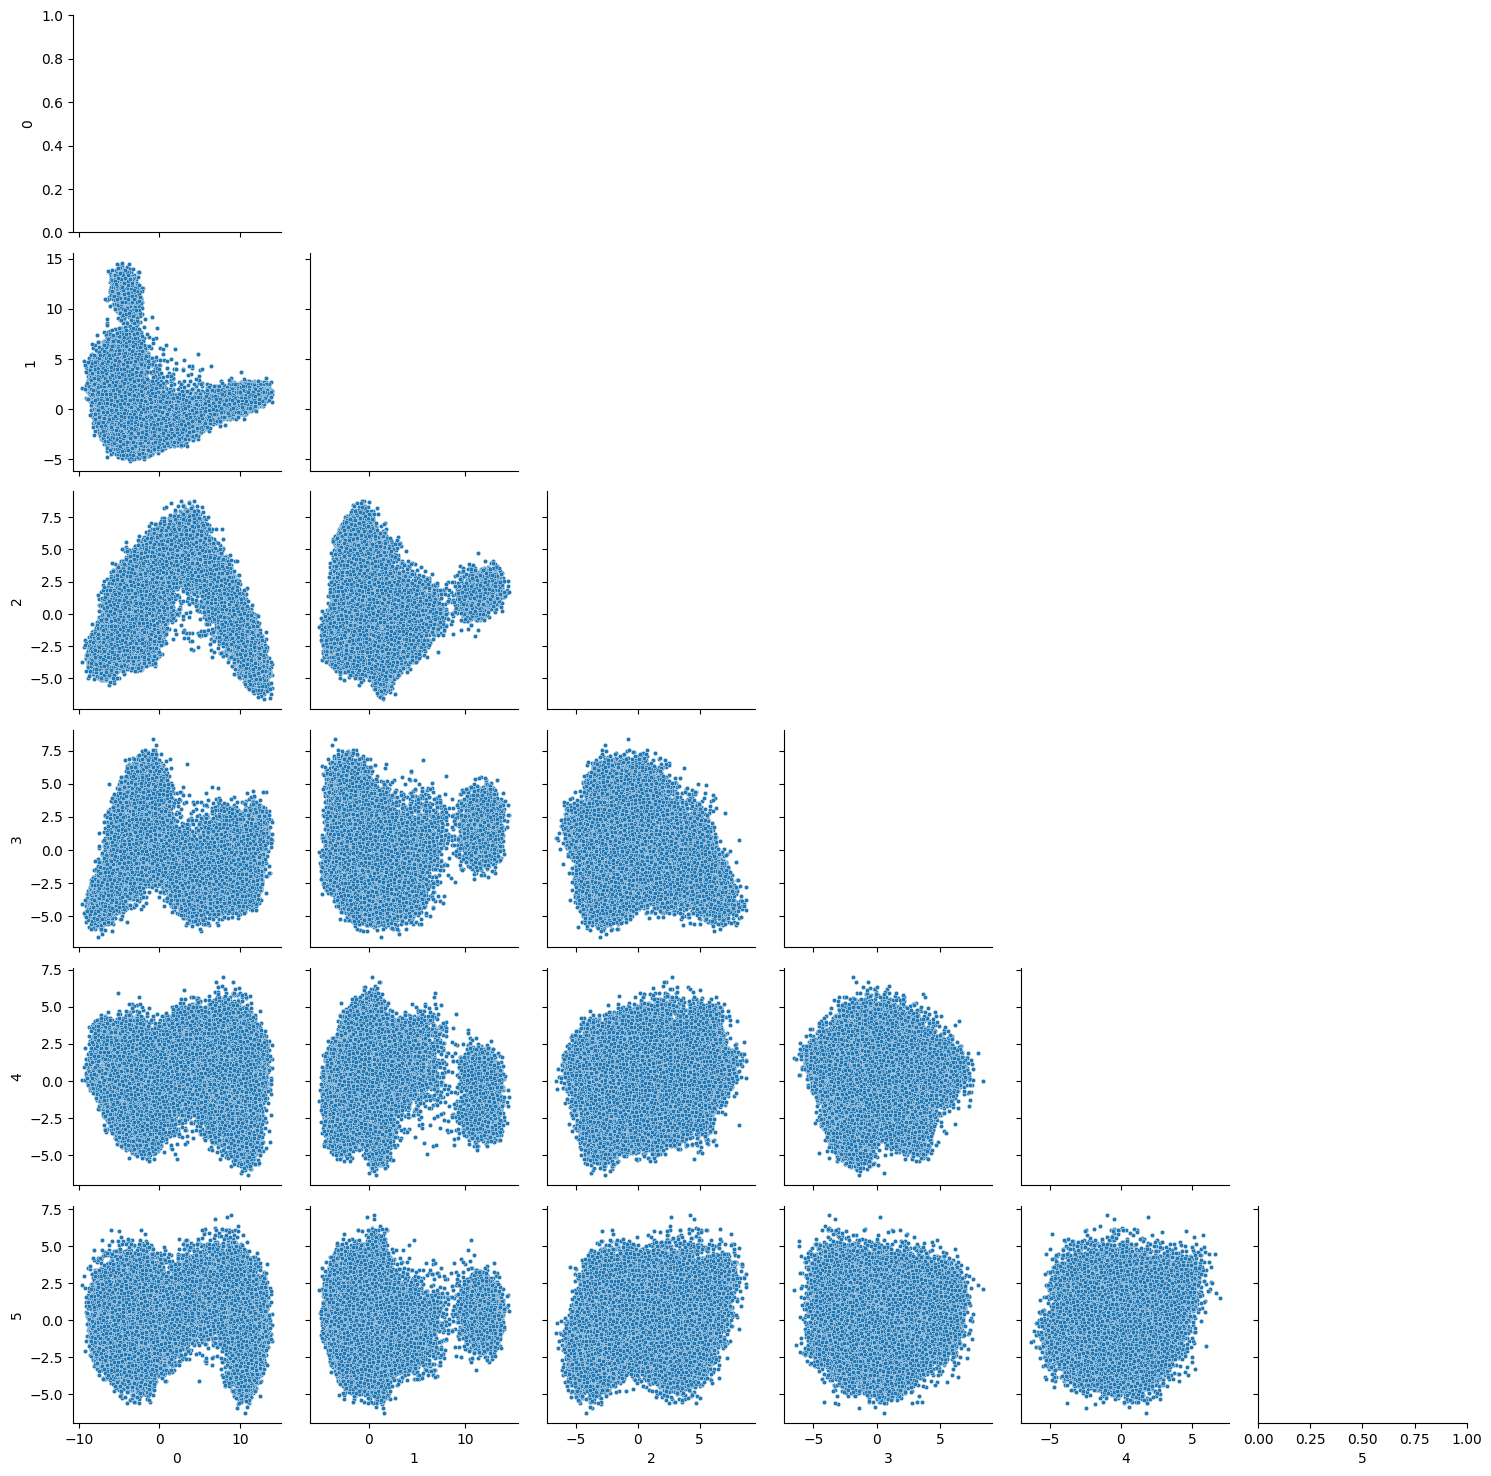

In [25]:
fig = sns.PairGrid(pd.DataFrame(adata.obsm["X_pca"][:,:6]), diag_sharey=False, corner=True)
fig.map_lower(sns.scatterplot,s=10)
fig.savefig(f"results/{analysis_name}/dr_pcs.{save_format}")      

### UMAP representation

In [26]:
parameters['n_pcs']=int(parameters['n_pcs'])

In [27]:
sp.pp.neighbors(adata, 
                metric=parameters["metric"], 
                n_pcs=parameters['n_pcs'],
                use_rep="X_pca",
                key_added="neighbors_pca",
                n_neighbors=10,
)
sp.tl.umap(adata, neighbors_key="neighbors_pca")
adata.obsm["X_umap_pca"] = adata.obsm["X_umap"].copy()

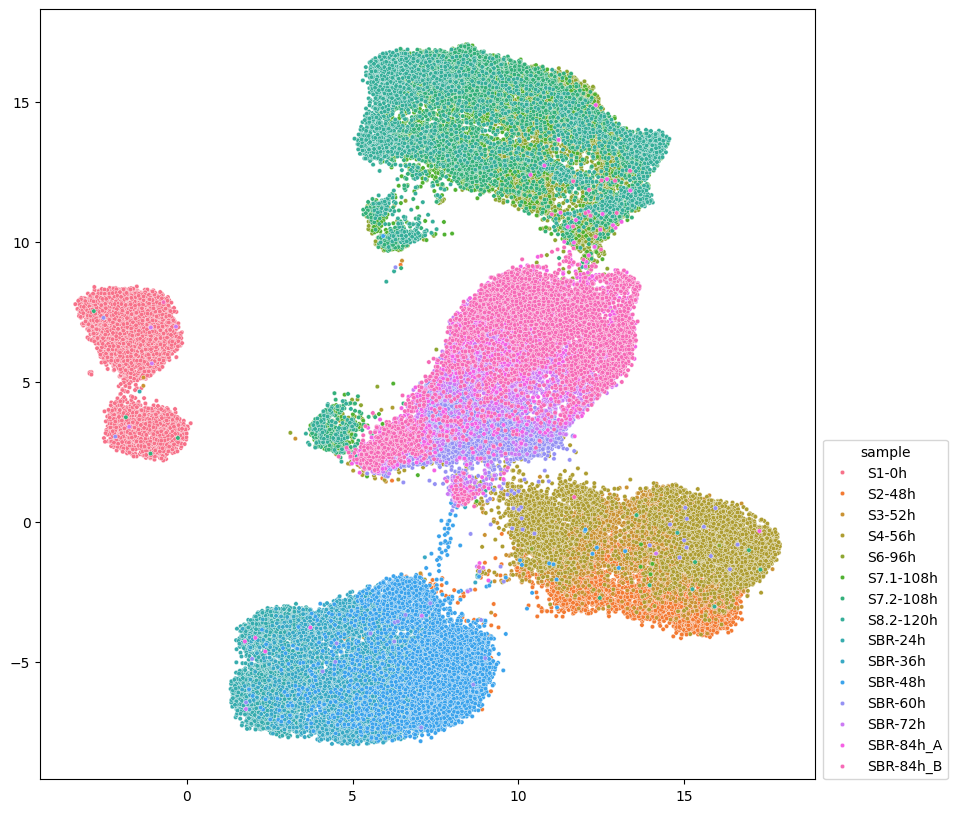

In [28]:
for hue in ["sample"]:            
    fig,ax = plt.subplots(figsize=[10,10])
    sns.scatterplot(x=adata.obsm["X_umap_pca"][:,0],y=adata.obsm["X_umap_pca"][:,1],hue=adata.obs[hue],s=10)
    ax.legend(loc=(1.01,0),title=hue)
    fig.savefig(f"results/{analysis_name}/dr_umap_pca.{save_format}")

## 3. Batch correction: scvi

In [29]:
adata_ = adata[:,adata.var["highly_variable"].values]
adata_ = adata_.copy()

In [30]:
scvi.model.SCVI.setup_anndata(adata_,batch_key="sample")
vae = scvi.model.SCVI(adata_)
vae.train(early_stopping=True,check_val_every_n_epoch=1,early_stopping_monitor='elbo_validation')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 19/115:  16%|█▌        | 18/115 [01:06<05:51,  3.62s/it, v_num=1, train_loss_step=711, train_loss_epoch=724]

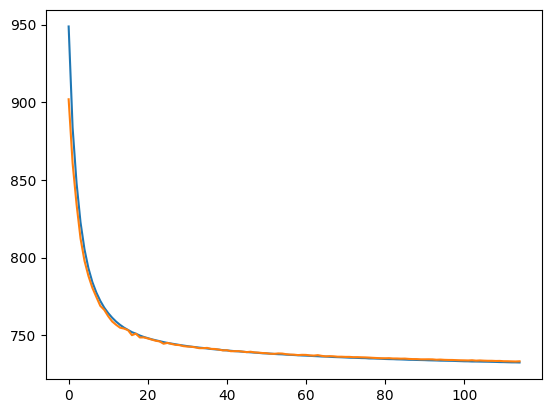

In [ ]:
plt.plot(vae.history["elbo_train"].values)
plt.plot(vae.history["elbo_validation"].values)

In [ ]:
adata.obsm["X_scvi"] = vae.get_latent_representation()

In [ ]:
sp.pp.neighbors(adata, 
                metric=parameters["metric"], 
                use_rep="X_scvi",
                key_added="neighbors_scvi",
                n_neighbors=10,
)
sp.tl.umap(adata, neighbors_key="neighbors_scvi")
adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"].copy()

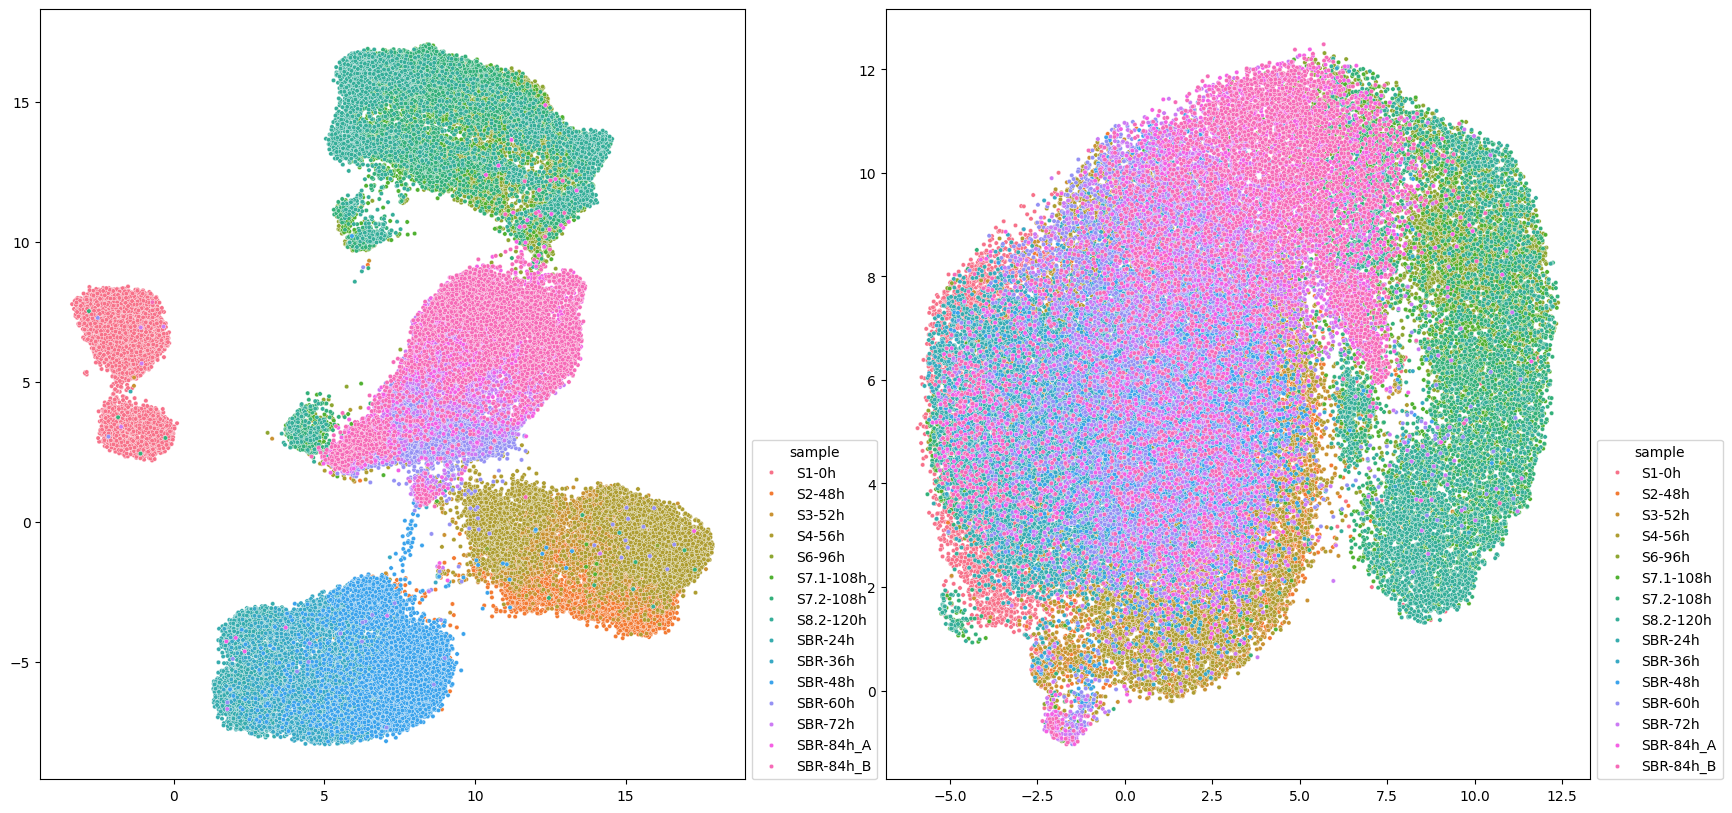

In [ ]:
for hue in ["sample"]:            
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    order = np.argsort(adata.obs[hue])
    sns.scatterplot(x=adata.obsm["X_umap_pca"][order,0],y=adata.obsm["X_umap_pca"][order,1],hue=adata.obs[hue],s=10, ax=ax[0])
    ax[0].legend(loc=(1.01,0),title=hue)

    order = np.argsort(adata.obs[hue])
    sns.scatterplot(x=adata.obsm["X_umap_scvi"][order,0],y=adata.obsm["X_umap_scvi"][order,1],hue=adata.obs[hue][order],s=10, ax=ax[1])
    ax[1].legend(loc=(1.01,0),title=hue)
    fig.savefig(f"results/{analysis_name}/dr_umap_pca_vs_scvi.{save_format}")    

## Save

In [ ]:
adata.write(f"{data_folder}/{analysis_name}_processed.h5ad")

## Load file

In [ ]:
# read file
adata=sp.read_h5ad(f"{data_folder}/{analysis_name}_processed.h5ad")

# 4. Marker genes 

In [ ]:
if 'pijuan_integrated' in analysis_name:
        ad = sp.read_h5ad(f"{data_folder}/pijuan_E7.5_3.h5ad")
        symbols = ad.var['mgi_symbol'].values
        adata.var_names=symbols

In [ ]:
genes=["T", "Snai1","Cdh1","Cdh2","Noto","Foxa2","Nanog","Zfp42"]

In [ ]:
for gene in genes:
    for t in adata.obs["stage"].unique():
        fig,ax = plt.subplots(1,1,figsize=[2.32,2.32])

        # gene expression
        hue = adata[adata.obs.stage==t][:,gene].X.toarray()[:,0]
        sns.scatterplot(x=adata[adata.obs.stage==t].obsm["X_umap_scvi"][:,0],y=adata[adata.obs.stage==t].obsm["X_umap_scvi"][:,1],hue=hue,s=5,ax=ax)

        ax.set_title(gene, fontsize=7)
        ax.legend(title=t, title_fontsize=5, prop={'size':5}, loc=(1.01,0.005))

        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        
        os.makedirs(f'results/{analysis_name}/umap_genes/', exist_ok=True)
        fig.savefig(f"results/{analysis_name}/umap_genes/umap_{gene}_{t}.{save_format}", dpi=300, bbox_inches='tight')    
        plt.close()